In [90]:
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 12, 7

In [91]:
def parser(x):
    return datetime.strptime(x,'%Y-%m')


data=pd.read_csv('importofrice.csv', index_col=0 ,parse_dates = [0], date_parser = parser)
training_data = data[:round(len(data)*0.85)]
test_data = data[round(len(data)*0.85):]

/home/redeye/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [92]:
# from datetime import datetime
len_training = len(training_data)
len_training

102

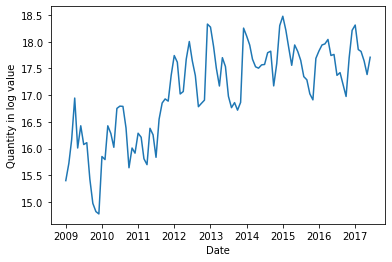

In [93]:
training_data_logscale = np.log(training_data)
plt.xlabel("Date")
plt.ylabel("Quantity in log value")
plt.plot(training_data_logscale)

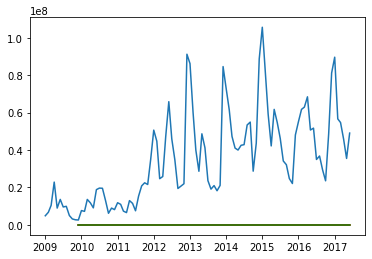

In [94]:
movingavg = training_data_logscale.rolling(window=12).mean()
movingstd = training_data_logscale.rolling(window=12).std()
plt.plot(training_data)
plt.plot(movingavg, 'red')
plt.plot(movingstd, 'green')

In [95]:
datasetlogscalemovingavg = training_data_logscale - movingavg
datasetlogscalemovingavg.head(12)

datasetlogscalemovingavg.dropna(inplace=True)
datasetlogscalemovingavg.head(10)

,Quantity
Month,
2009-12-01,-0.959901
2010-01-01,0.075556
2010-02-01,0.012921
2010-03-01,0.622041
2010-04-01,0.533603
2010-05-01,0.274571
2010-06-01,0.974173
2010-07-01,0.957035
2010-08-01,0.895830


In [96]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    movingavg = timeseries.rolling(window=12).mean()
    movingstd = timeseries.rolling(window=12).std()
    
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(movingavg,color='red',label='Rolling Mean')
    std = plt.plot(movingstd,color='green',label='Rolling Std')

    
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(training_data['Quantity'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Values (%s)'%key] = value

Result of Dickey-Fuller Test:


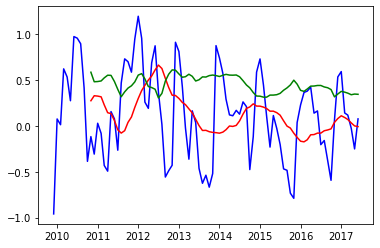

In [97]:
test_stationarity(datasetlogscalemovingavg)

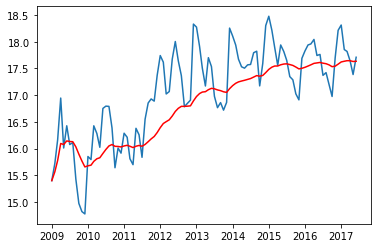

In [98]:
exp_decay_wt_avg = training_data_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(training_data_logscale)
plt.plot(exp_decay_wt_avg,color='red')

Result of Dickey-Fuller Test:


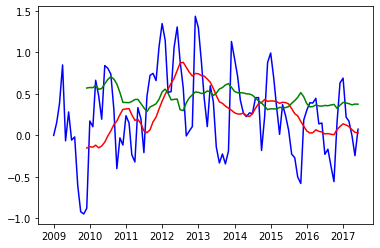

In [99]:
data_logscale_minus_moving_exp_decay_avg = training_data_logscale - exp_decay_wt_avg
test_stationarity(data_logscale_minus_moving_exp_decay_avg)

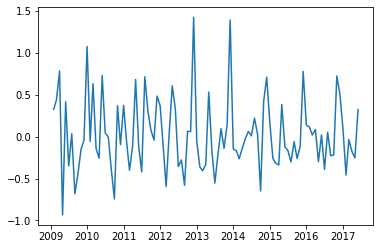

In [100]:
datasetlogdiffshifting = training_data_logscale - training_data_logscale.shift()
plt.plot(datasetlogdiffshifting)

Result of Dickey-Fuller Test:


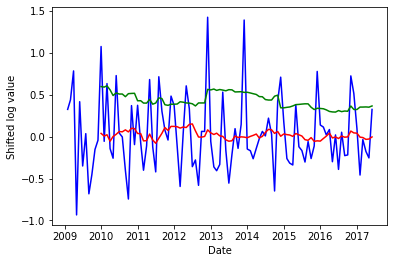

In [101]:
datasetlogdiffshifting.dropna(inplace=True)
plt.xlabel("Date")
plt.ylabel("Shifted log value")
test_stationarity(datasetlogdiffshifting)

Result of Dickey-Fuller Test:


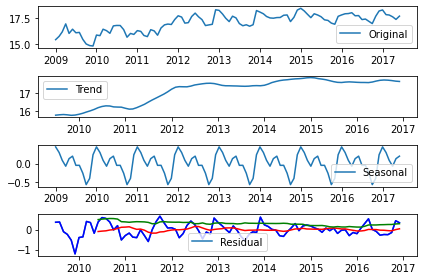

In [102]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(training_data_logscale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(training_data_logscale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')

plt.tight_layout()

decompositionlogdata = residual
decompositionlogdata.dropna(inplace=True)
test_stationarity(decompositionlogdata)

Result of Dickey-Fuller Test:


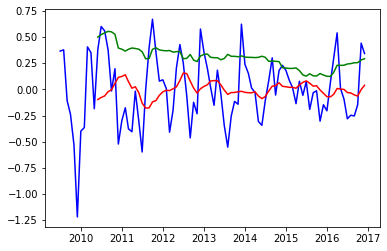

In [103]:
decompositionlogdata = residual
decompositionlogdata.dropna(inplace=True)
test_stationarity(decompositionlogdata)

/home/redeye/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Text(0.5, 1.0, 'Autocorrelation function')

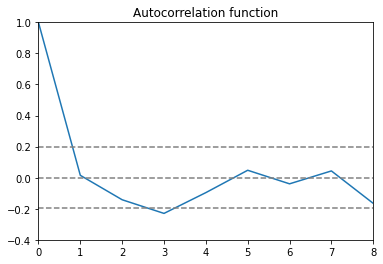

In [104]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetlogdiffshifting,nlags=20)
lag_pacf = pacf(datasetlogdiffshifting, nlags=20, method='ols')

#plt.subplot(121)
plt.axis([0, 8, -0.4, 1.0])
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='gray')
plt.title('Autocorrelation function')



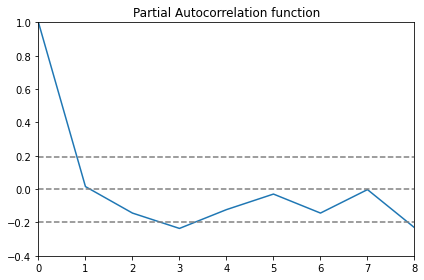

In [105]:
#plt.subplot(122)
plt.axis([0, 8, -0.4, 1.0])
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation function')
plt.tight_layout()

/home/redeye/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/redeye/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


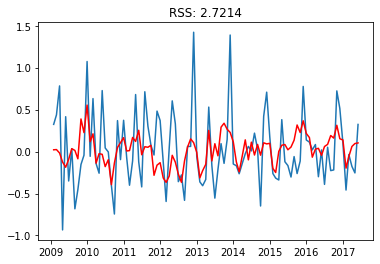

In [108]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(training_data_logscale,order=(7,1,2))
results_ar = model.fit(disp=-1)
results_ar.fittedvalues
plt.plot(datasetlogdiffshifting)
plt.plot(results_ar.fittedvalues,color='red')
results_ar.fittedvalues
rss = np.log(sum((results_ar.fittedvalues-datasetlogdiffshifting["Quantity"])**2))
plt.title('RSS: %.4f'% rss)
print('Plotting AR model')

In [109]:
predic_arima_diff = pd.Series(results_ar.fittedvalues, copy=False)
print(predic_arima_diff.head())

Month
2009-02-01    0.021093
2009-03-01    0.023745
2009-04-01   -0.017432
2009-05-01   -0.125090
2009-06-01   -0.186935
dtype: float64


In [110]:
predic_arima_diff_cumsum = predic_arima_diff.cumsum()
print(predic_arima_diff_cumsum.head())

Month
2009-02-01    0.021093
2009-03-01    0.044839
2009-04-01    0.027406
2009-05-01   -0.097684
2009-06-01   -0.284619
dtype: float64


In [111]:
predic_arima_log = pd.Series(training_data_logscale['Quantity'],index=training_data_logscale.index)
predic_arima_log = predic_arima_log.add(predic_arima_diff_cumsum, fill_value=0)
predic_arima=np.exp(predic_arima_log)
predic_arima

Month
2009-01-01    4.889152e+06
2009-02-01    6.903537e+06
2009-03-01    1.094869e+07
2009-04-01    2.352230e+07
2009-05-01    8.159418e+06
                  ...     
2017-02-01    3.316236e+08
2017-03-01    3.018801e+08
2017-04-01    2.686746e+08
2017-05-01    2.291470e+08
2017-06-01    3.508902e+08
Length: 102, dtype: float64

In [112]:
predic_arima = np.exp(predic_arima_log)
exp_log_indexdata = np.exp(training_data_logscale)
# plt.plot(exp_log_indexdata)
# plt.plot(predic_arima)

In [113]:
#indexdata_logscale
# exp_log_indexdata
predic_arima

Month
2009-01-01    4.889152e+06
2009-02-01    6.903537e+06
2009-03-01    1.094869e+07
2009-04-01    2.352230e+07
2009-05-01    8.159418e+06
                  ...     
2017-02-01    3.316236e+08
2017-03-01    3.018801e+08
2017-04-01    2.686746e+08
2017-05-01    2.291470e+08
2017-06-01    3.508902e+08
Length: 102, dtype: float64

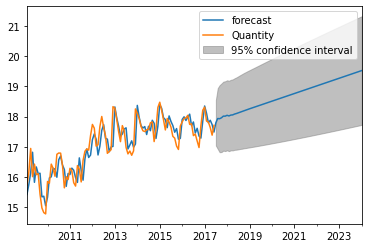

In [114]:
np.exp(training_data_logscale)
# x =results_ar.plot_predict(1,180)
x=results_ar.plot_predict(start=1, end=180, exog=None, dynamic=False, alpha=0.05, plot_insample=True, ax=None)
# print arma_order_select_ic(df.AverageTemperature, ic=['aic', 'bic'], trend='nc',
#             max_ar=4, max_ma=4, fit_kw={'method': 'css-mle'})

In [115]:
pred=results_ar.forecast(steps = 60)[0]
# pred
# pred = np.exp(pred)
y = pred.tolist()
s = pd.Series(y, copy = False)
# type(s)
s=np.exp(s)
s

0     5.349564e+07
1     6.158417e+07
2     6.120069e+07
3     6.313125e+07
4     6.666013e+07
5     6.660945e+07
6     6.851676e+07
7     6.707626e+07
8     6.904123e+07
9     6.942947e+07
10    7.141102e+07
11    7.268937e+07
12    7.436438e+07
13    7.628040e+07
14    7.789214e+07
15    7.990426e+07
16    8.142397e+07
17    8.333502e+07
18    8.495729e+07
19    8.681578e+07
20    8.859165e+07
21    9.045428e+07
22    9.238350e+07
23    9.431911e+07
24    9.636724e+07
25    9.839683e+07
26    1.005283e+08
27    1.026588e+08
28    1.048638e+08
29    1.070956e+08
30    1.093795e+08
31    1.117124e+08
32    1.140880e+08
33    1.165234e+08
34    1.190017e+08
35    1.215416e+08
36    1.241296e+08
37    1.267776e+08
38    1.294797e+08
39    1.322403e+08
40    1.350600e+08
41    1.379387e+08
42    1.408800e+08
43    1.438825e+08
44    1.469502e+08
45    1.500824e+08
46    1.532820e+08
47    1.565494e+08
48    1.598866e+08
49    1.632950e+08
50    1.667760e+08
51    1.703313e+08
52    1.7396

In [116]:
training_data=training_data.reset_index()
training_data

,Month,Quantity
0,2009-01-01,4889152
1,2009-02-01,6759443
2,2009-03-01,10468605
3,2009-04-01,22886390
4,2009-05-01,8996689
...,...,...
97,2017-02-01,56670622
98,2017-03-01,54716003
99,2017-04-01,45823553
100,2017-05-01,35528376


In [117]:
for x in range(len(s)):
    if(training_data.Month[len(training_data)-1].month < 12):
        m = training_data.Month[len(training_data)-1].month + 1
        y = training_data.Month[len(training_data)-1].year
    else:
        y = training_data.Month[len(training_data)-1].year + 1 
        m = 1
    d = '{}-{}'.format(y,m)
    d = datetime.strptime(d, '%Y-%m')
    training_data = training_data.append({'Month': d, 'Quantity': s[x]}, ignore_index=True)

/home/redeye/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  if __name__ == '__main__':


In [118]:
training_data

,Month,Quantity
0,2009-01-01,4.889152e+06
1,2009-02-01,6.759443e+06
2,2009-03-01,1.046860e+07
3,2009-04-01,2.288639e+07
4,2009-05-01,8.996689e+06
...,...,...
157,2022-02-01,1.853265e+08
158,2022-03-01,1.892772e+08
159,2022-04-01,1.933121e+08
160,2022-05-01,1.974331e+08


In [119]:
training_data.set_index("Month", inplace = True)
training_data

,Quantity
Month,
2009-01-01,4.889152e+06
2009-02-01,6.759443e+06
2009-03-01,1.046860e+07
2009-04-01,2.288639e+07
2009-05-01,8.996689e+06
...,...
2022-02-01,1.853265e+08
2022-03-01,1.892772e+08
2022-04-01,1.933121e+08


In [120]:
original_data_plot = training_data[:len_training]
original_data_plot

,Quantity
Month,
2009-01-01,4889152.0
2009-02-01,6759443.0
2009-03-01,10468605.0
2009-04-01,22886390.0
2009-05-01,8996689.0
...,...
2017-02-01,56670622.0
2017-03-01,54716003.0
2017-04-01,45823553.0


In [121]:
predicted_data = training_data[len_training:]
predicted_data

,Quantity
Month,
2017-07-01,5.349564e+07
2017-08-01,6.158417e+07
2017-09-01,6.120069e+07
2017-10-01,6.313125e+07
2017-11-01,6.666013e+07
2017-12-01,6.660945e+07
2018-01-01,6.851676e+07
2018-02-01,6.707626e+07
2018-03-01,6.904123e+07


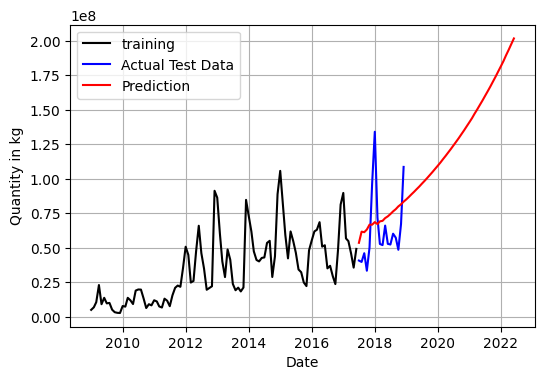

In [122]:
plt.figure(figsize=(6,4), dpi=100)
plt.xlabel("Date")
plt.ylabel("Quantity in kg")
plt.plot(original_data_plot,color = 'black', label='training')
plt.plot(test_data, color = 'blue', label='Actual Test Data')
plt.plot(predicted_data, color = 'red',label='Prediction')
plt.grid()
plt.legend(loc='best')